# Congruent number prediction using Selmer groups and modular degree

The notebook contains ML experiments to classify and predict congruent numnbers. We use $2$-Selmer rank, $3$-Selmer rank and modular degree as features. The following ML models are used

- logistic regression,
- random forest,
- gradient boost,
- XGboost,
- descision tree classifier.


In [2]:
import pandas as pd

# --- Configuration ---

file1 = "data_with_mod8.csv"
file2 = "threeselmer.csv"
file3 = "sqfr1mil_with_modDegree.csv"

# Specify the columns to keep from each file (including 'n')
cols_file1 = ["n", "2selmer_rank", "iscongruent", "mod8"]  # Replace with actual column names from file1
cols_file2 = ["n", "3selmer_rank"]  # Replace with actual column names from file2
cols_file3 = ["n", "v2_modegree"]
# --- Load and preprocess each file ---

df1 = pd.read_csv(file1, usecols=cols_file1).set_index("n")
df2 = pd.read_csv(file2, usecols=cols_file2).set_index("n")
df3 = pd.read_csv(file3, usecols=cols_file3).set_index("n")

# --- Join on common 'n' values only ---

combined_df = df1.join(df2, how="inner").join(df3, how="inner")  # intersection of n

# --- Result ---

print(combined_df)  # preview

# Optional: save to a new CSV
combined_df.to_csv("cn_pred_selmer.csv")


        2selmer_rank  iscongruent  mod8  3selmer_rank  v2_modegree
n                                                                 
1                  2            0     1             0            1
1                  2            0     1             0            1
2                  2            0     2             0            1
2                  2            0     2             0            1
3                  2            0     3             0            4
...              ...          ...   ...           ...          ...
104933             3            1     5             1            6
104935             3            1     7             1           24
104937             2            0     1             0           23
104939             2            0     3             0           15
104941             5            1     5             1           16

[65010 rows x 5 columns]


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Load data ===
csv_file = 'cn_pred_selmer.csv'  # Change to your filename
df = pd.read_csv(csv_file)

print(df)

len_0 = df[df['iscongruent'] == 0].shape[0]
df_balanced = df[df['iscongruent'] == 1].sample(len_0) 
df_balanced = pd.concat([df_balanced, df[df['iscongruent'] == 0]])
print(df_balanced.iscongruent.value_counts())

# === Features and target ===
feature_cols = ["2selmer_rank", "3selmer_rank", 'mod8']
X = df_balanced[feature_cols]
y = df_balanced['iscongruent']

            n  2selmer_rank  iscongruent  mod8  3selmer_rank  v2_modegree
0           1             2            0     1             0            1
1           1             2            0     1             0            1
2           2             2            0     2             0            1
3           2             2            0     2             0            1
4           3             2            0     3             0            4
...       ...           ...          ...   ...           ...          ...
65005  104933             3            1     5             1            6
65006  104935             3            1     7             1           24
65007  104937             2            0     1             0           23
65008  104939             2            0     3             0           15
65009  104941             5            1     5             1           16

[65010 rows x 6 columns]
iscongruent
1    28558
0    28558
Name: count, dtype: int64


In [4]:
# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Feature scaling ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [5]:
# === Models to train ===
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'DTC': DecisionTreeClassifier()
}


Logistic Regression
Accuracy:  0.9609
Precision: 0.9645
Recall:    0.9569
F1 Score:  0.9607
ROC AUC:   0.9919


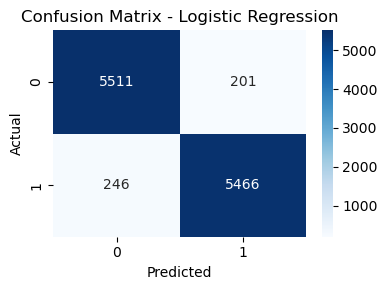


Random Forest
Accuracy:  0.9624
Precision: 0.9674
Recall:    0.9569
F1 Score:  0.9622
ROC AUC:   0.9969


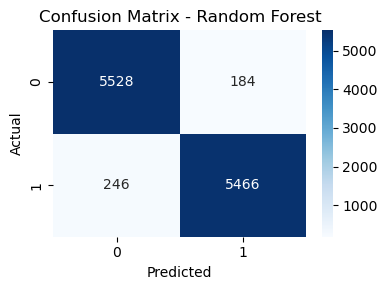


Gradient Boosting
Accuracy:  0.9624
Precision: 0.9674
Recall:    0.9569
F1 Score:  0.9622
ROC AUC:   0.9969


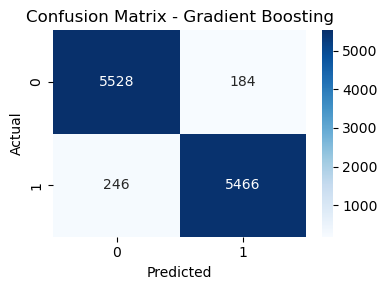


XGBoost
Accuracy:  0.9624
Precision: 0.9674
Recall:    0.9569
F1 Score:  0.9622
ROC AUC:   0.9969


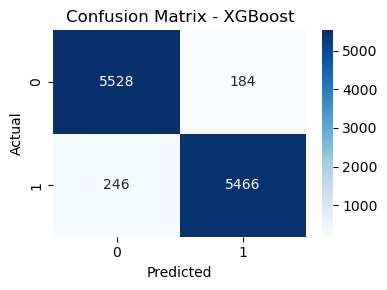


DTC
Accuracy:  0.9624
Precision: 0.9674
Recall:    0.9569
F1 Score:  0.9622
ROC AUC:   0.9969


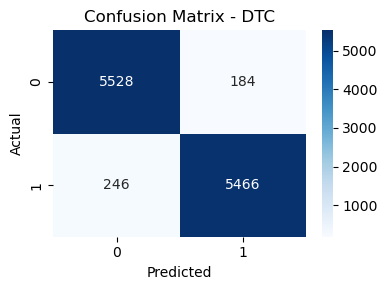

In [6]:
# === Train and evaluate ===
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]  # needed for ROC AUC

    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{name}")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")

    # Confusion Matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()